# Theta modulation index during MAZE

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d
import subjects

sessions = subjects.nsd.ratUday2

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
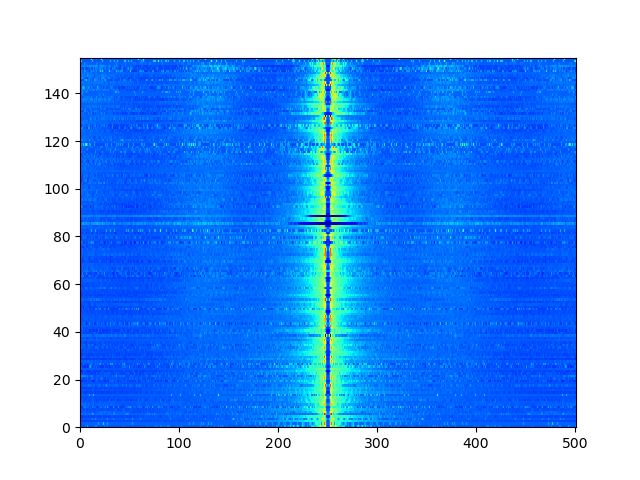

In [3]:
%matplotlib widget
for sub,sess in enumerate(sessions):
    maze = sess.paradigm["maze"]
    post = sess.paradigm['post']
    maze_neurons = (
        sess.neurons.get_neuron_type("pyr")
        .time_slice(maze[0], maze[1])
        .get_above_firing_rate(0.05)
    )
    acg = neurons_util.calculate_neurons_acg(maze_neurons, bin_size=0.001, window_size=0.5)
    acg_right = acg[:, acg.shape[1] // 2 :]
    trough, peak = (acg_right[:, 50:70]).sum(axis=1), (acg_right[:, 100:140]).sum(
        axis=1
    )
    tmi = (peak - trough) / (peak + trough)

    norm_acg = gaussian_filter1d(stats.zscore(acg,axis=1),sigma=0.5)

    sort_ind = np.argsort(tmi)
    plt.pcolormesh(norm_acg[sort_ind,:],cmap='jet')
    

# How does theta modulated cells behave during sleep deprivation
- do they decrease their firing rate during SD more than non-theta modulated cells

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.utils import neurons_util
from neuropy.plotting import Fig
import pandas as pd
from scipy import stats
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [16]:
bin_size = 15*60
nQuantiles = 5

theta_mod_frate = pd.DataFrame()
for grp, sessions in zip(['sd','nsd'],[sd_sessions,nsd_sessions]):
    post_frate=[]
    quantiles=[]
    for sub, sess in enumerate(sessions):
        maze = sess.paradigm["maze"]
        post = sess.paradigm['post']
        maze_neurons = (
            sess.neurons.get_neuron_type("pyr")
            .time_slice(maze[0], maze[1])
            .get_above_firing_rate(0.05)
        )
        acg = neurons_util.calculate_neurons_acg(maze_neurons, bin_size=0.001, window_size=0.5)
        acg_right = acg[:, acg.shape[1] // 2 :]
        trough, peak = (acg_right[:, 50:70]).sum(axis=1), (acg_right[:, 100:140]).sum(
            axis=1
        )
        tmi = (peak - trough) / (peak + trough)
        quantiles.append(pd.qcut(tmi, q=nQuantiles, labels=False))
        neuron_ids_bool = np.isin(sess.neurons.neuron_ids,maze_neurons.neuron_ids)
        binspk = sess.neurons[neuron_ids_bool].time_slice(
                    post[0], post[0] + 9 * 3600
                ).get_binned_spiketrains(bin_size=bin_size)
        post_frate.append(binspk.spike_counts/bin_size)

    quantiles = np.concatenate(quantiles)
    post_frate = np.vstack(post_frate)
    assert len(quantiles) == post_frate.shape[0],'First dimension should match'

    quant_mean_frate = [
            np.nanmean(post_frate[quantiles == q, :], axis=0) for q in range(nQuantiles)
        ]
    quant_mean_frate = np.asarray(quant_mean_frate)
    first_bin = quant_mean_frate[:, 0]
    quant_mean_frate = quant_mean_frate / first_bin[:, np.newaxis]

    df = pd.DataFrame(
        quant_mean_frate, columns=np.arange(quant_mean_frate.shape[1])
    )
    df["grp"] = grp
    df["quantiles"] = np.arange(nQuantiles)
    theta_mod_frate = theta_mod_frate.append(df)

theta_mod_frate= pd.melt(
    theta_mod_frate,
    id_vars=["grp", "quantiles"],
    value_vars=np.arange(36),
    var_name=["bins"],
    value_name="frate",
    ignore_index=True,
)

theta_mod_frate['bins'] = theta_mod_frate['bins']*(bin_size/3600)

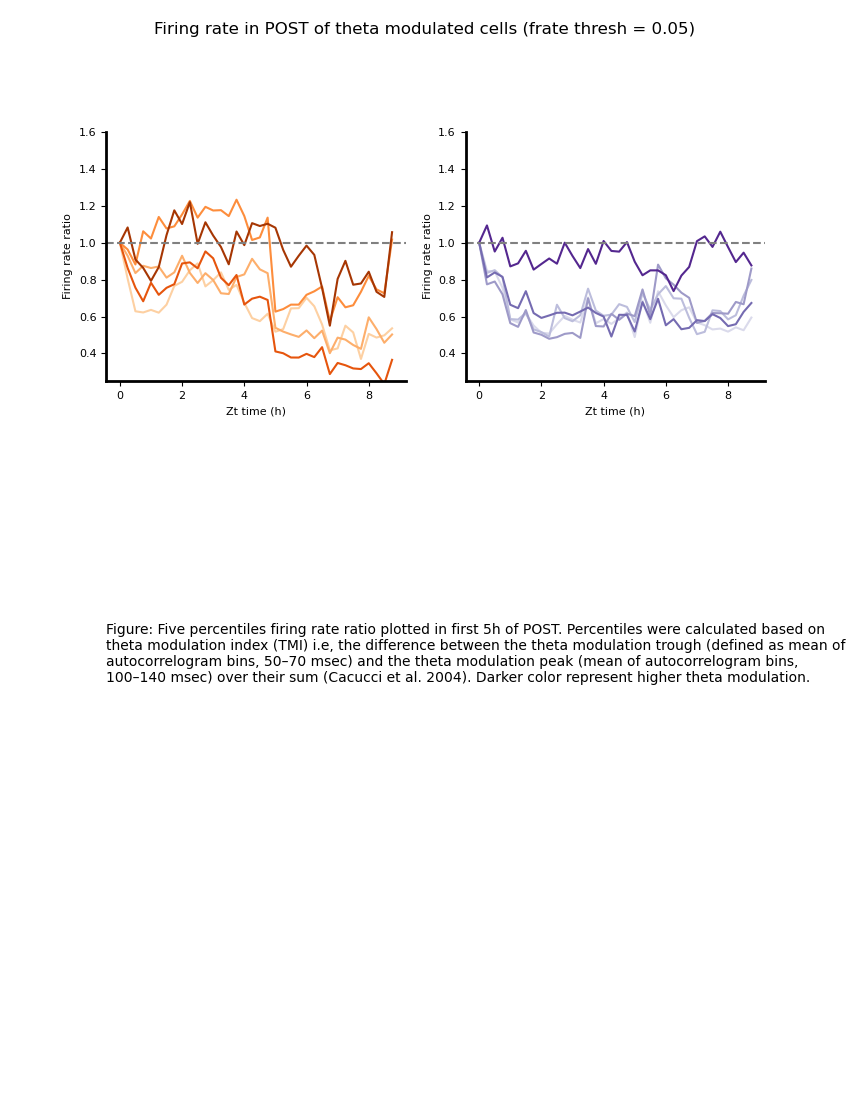

In [23]:
%matplotlib widget
import seaborn as sns
from palettable.colorbrewer.sequential import Oranges_6, Purples_6
from neuropy.plotting import Fig
figure = Fig()
fig,gs = figure.draw(grid=(3,2))

colors = list(subjects.sd_colors.values())
palette = [Oranges_6, Purples_6]
for i, grp in enumerate(["sd", "nsd"]):
    ax_1v5 = plt.subplot(gs[i])
    df = theta_mod_frate[(theta_mod_frate["grp"] == grp)]
    
    sns.lineplot(
        data=df,
        x="bins",
        y="frate",
        hue="quantiles",
        palette=palette[i].hex_colors[1:],
        legend=None,
        ax=ax_1v5
    )   
    # ax_1v5.set_yscale('log')
    ax_1v5.axhline(1,ls='--',color='gray')
    ax_1v5.set_ylim(bottom=0.25,top=1.6)
    ax_1v5.set_ylabel('Firing rate ratio')
    ax_1v5.set_xlabel('Zt time (h)')
    # if i==0:
        # figure.panel_label(ax_1v5,'E')

ax_caption = plt.subplot(gs[1, :])
ax_caption.text(
    0,
    0,
    "Figure: Five percentiles firing rate ratio plotted in first 5h of POST. Percentiles were calculated based on theta modulation index (TMI) i.e, the difference between the theta modulation trough (defined as mean of autocorrelogram bins, 50–70 msec) and the theta modulation peak (mean of autocorrelogram bins, 100–140 msec) over their sum (Cacucci et al. 2004). Darker color represent higher theta modulation.",
    wrap=True,
)
ax_caption.axis("off")
fig.suptitle('Firing rate in POST of theta modulated cells (frate thresh = 0.05)')
figure.savefig(subjects.figpath_sd/'theta_modulation_frate_POST')